In [10]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

# Import the re module for working with regular expressions,
# which is useful for pattern matching and text processing tasks.
import re

# Import the spacy library for advanced natural language processing (NLP) tasks,
# such as tokenization, named entity recognition, and dependency parsing.
import spacy

# Import matplotlib.pyplot as plt for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt

# Import seaborn as sns, which provides a high-level interface for drawing attractive statistical graphics.
import seaborn as sns

# Import the Counter class from the collections module, which is useful for counting hashable objects (like words).
from collections import Counter

In [11]:
# Load Spacy's Named Entity Recognition (NER) model
nlp = spacy.load("en_core_web_sm")

In [12]:
# Loading the datasets of the three categories
df_LUXURY = pd.read_excel('/Users/iyayiiguodala/Downloads/scrapped data/LUXURY - excel/TEAM%204%20-%20DMS_2025310_146 (1).xlsx')
Midrange   = pd.read_excel('/Users/iyayiiguodala/Downloads/scrapped data/MIDRANGE - EXCEL/TEAM%204%20-%20DMS_2025310_141.xlsx')
Drugstore  = pd.read_excel('/Users/iyayiiguodala/Downloads/scrapped data/DRUGSTORE/TEAM%204%20-%20DMS_2025310_1333.xlsx')

# Rename columns for consistency
rename_mapping = {
    'Unnamed: 1': 'Date',
    'Unnamed: 2': 'Message',
    'Unnamed: 3': 'Profile',
    'Unnamed: 4': 'Network',
    'Unnamed: 5': 'Number of Likes',
    'Unnamed: 6': 'Number of Comments',
    'Unnamed: 7': 'Reactions',
    'Unnamed: 8': 'Post interaction rate',
    'Unnamed: 9': 'Reach per post',
    'Unnamed: 10': 'Interactions per impression',
    'Unnamed: 11': 'Post comments negative sentiment share',
    'Unnamed: 12': 'Engagement rate',
    'Unnamed: 13': 'Click-through rate (CTR)',
    'Unnamed: 14': 'Impressions',
    'Unnamed: 15': 'Message-ID',
    'Unnamed: 16': 'Profile-ID',
    'Unnamed: 17': 'Link',
    'Unnamed: 18': 'External Links'
}


df_LUXURY = df_LUXURY.rename(columns=rename_mapping)
Midrange   = Midrange.rename(columns=rename_mapping)
Drugstore  = Drugstore.rename(columns=rename_mapping)

In [13]:
# Remove any leftover unnamed columns from the original DataFrames.
# These typically result from empty columns in the Excel source files.
df_LUXURY = df_LUXURY.drop([col for col in df_LUXURY.columns if isinstance(col, str) and col.startswith("Unnamed")], axis=1)
Midrange  = Midrange.drop([col for col in Midrange.columns if isinstance(col, str) and col.startswith("Unnamed")], axis=1)
Drugstore = Drugstore.drop([col for col in Drugstore.columns if isinstance(col, str) and col.startswith("Unnamed")], axis=1)

In [14]:
# Combining the dataset to a new dataframe
merged_df = pd.concat([df_LUXURY, Midrange], ignore_index=True)
merged_df.head()

print(merged_df.shape)

(10000, 18)


In [15]:
# Cleaning up the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

merged_df['clean_message'] = merged_df['Message'].astype(str).apply(clean_text)

In [16]:
# Exact brand names as they appear in your data
brands = luxury_brands = [
    "Lancôme Official",
    "Dior Beauty Official",
    "Clé de Peau Beauté | クレ・ド・ポー ボーテ",
    "TOM FORD BEAUTY",
    "Estée Lauder",
    "wet n wild beauty",
    "Sisley Paris",
    "YSL Beauty Official",
    "CHANEL BEAUTY",
    "Guerlain"
]

midrange_brands = [
    "NARS Cosmetics",
    "M·A·C Cosmetics",
    "FENTY BEAUTY BY RIHANNA",
    "Urban Decay Cosmetics",
    "Too Faced Cosmetics",
    "Glossier",
    "Benefit Cosmetics US",
    "wet n wild beauty",
    "Tarte Cosmetics",
    "HUDA BEAUTY",
    "Smashbox Cosmetics"
]

drugstore_brands = [
    "L'Oréal Paris Official",
    "Revlon",
    "Maybelline New York",
    "NYX Professional Makeup",
    "wet n wild beauty",
    "Milani Cosmetics",
    "e.l.f. Cosmetics and Skincare",
    "COVERGIRL",
    "Physicians Formula",
    "Rimmel London US"
]

def find_brands(text):
    found_brands = [brand for brand in brands if brand in text]
    return ", ".join(found_brands) if found_brands else "No Brand Mentioned"

merged_df['identified_brands'] = merged_df['clean_message'].apply(find_brands)

In [17]:
# Detecting Unrealistic Beauty Content with the vocabulary
unrealistic_keywords = [
    "flawless", "porcelain", "airbrushed", "wrinkle-free", "even-toned", "radiant", "poreless",
    "blemish-free", "glowing", "youthful", "perfect", "symmetrical", "sculpted", "lifted",
    "snatched", "chiseled", "sharp", "contoured", "v-shaped", "button-like", "proportionate",
    "botoxed", "hollywood", "aligned", "bright", "smooth", "unlined", "refined", "sculpted",
    "plump", "hydrated", "full", "defined", "snatched", "chiseled", "no pores", "no wrinkles",
    "glossy", "sensual", "flawlessly", "perfectly", "ideal", "zero fat", "no blemishes", 
    "pearly-white", "whitened", "voluminous", "youthful", "lifted", "no dark circles", 
    "glass skin", "no fine lines", "even skin tone", "no visible veins", "perfectly shaped",
    "plumped", "smooth jawline", "always glowing", "never oily", "no visible pores", "no acne",
    "no redness", "no discoloration", "bright eyes", "refined nose", "full lips", "poreless skin"
]

def find_unrealistic(text):
    found_keywords = [kw for kw in unrealistic_keywords if kw in text]
    return ", ".join(found_keywords) if found_keywords else "No unrealistic content"

merged_df['unrealistic_content'] = merged_df['clean_message'].apply(find_unrealistic)

In [18]:
# Function to check if a message contains unrealistic beauty standards and return 0 or 1
def detect_unrealistic_content(text):
    text_lower = text.lower()
    
    # Check if any unrealistic phrase exists in the message
    for phrase in unrealistic_keywords:
        if phrase in text_lower:
            return 1  # Match found, mark as unrealistic
    
    # Check if any unrealistic keyword exists in the message
    for word in unrealistic_keywords:
        if word in text_lower:
            return 1  # Match found, mark as unrealistic
    
    return 0  # No match found

# Apply the function to your DataFrame
# For example, if using the df_LUXURY DataFrame which has a 'clean_message' column:
merged_df['unrealistic_beauty'] = merged_df['clean_message'].apply(detect_unrealistic_content)

In [19]:
import pandas as pd
import numpy as np

# Define a function to extract the post type from a given URL.
# This function checks if the URL represents a video or a static image.
def extract_post_type(url):
    # Verify that the input is a string. If not, return NaN.
    if not isinstance(url, str):
        return np.nan
    # Convert the URL to lowercase, remove leading/trailing whitespace, and remove any trailing slash.
    url = url.lower().strip().rstrip('/')
    
    # Check if the URL indicates a video (contains '/reel/')
    if '/reel/' in url:
        return 1  # Return 1 for video posts.
    # Check if the URL indicates a static image (contains '/p/')
    elif '/p/' in url:
        return 0  # Return 0 for static image posts.
    else:
        # If the URL doesn't match known patterns, return NaN to indicate an unknown type.
        return np.nan

# Apply the extract_post_type function on the 'Link' column of merged_df to create a new 'post_type' column.
merged_df['post_type'] = merged_df['Link'].apply(extract_post_type)

# Convert the new 'post_type' column to a float data type.
# This ensures that the values are numeric (1.0 for video and 0.0 for static image).
merged_df['post_type'] = merged_df['post_type'].astype('float')

# Print the first few rows of the 'Link' and 'post_type' columns to verify the extraction and conversion.
print(merged_df[['Link', 'post_type']].head())

                                          Link  post_type
0     https://www.instagram.com/p/DHA8SUqtfqW/        0.0
1     https://www.instagram.com/p/DHA3Sa4tJJt/        0.0
2  https://www.instagram.com/reel/DHAS_79gLvk/        1.0
3     https://www.instagram.com/p/DG_cE4YNl5h/        0.0
4  https://www.instagram.com/reel/DG_Vdm6PFpU/        1.0


In [20]:
merged_df = pd.concat([merged_df, Drugstore], ignore_index=True)
print(merged_df.shape)

(15000, 23)


In [21]:
import re  # Import the regular expressions module for pattern matching and text manipulation.

# Define a function to clean the brand name (or any text) from unwanted elements.
def clean_brand_name(text):
    # Check if the input is a string. If not, return it unchanged.
    if not isinstance(text, str):
        return text
    # Convert the text to lowercase to standardize the text.
    text = text.lower()
    
    # Remove any URLs from the text using a regular expression.
    # This regex matches http, https, and www style URLs.
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username) and hashtags (#) from the text.
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Remove any special characters, keeping only lowercase letters, numbers, and whitespace.
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # Replace multiple spaces with a single space and trim leading/trailing whitespace.
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Return the cleaned text.
    return text

# Create a new column 'clean_message' in merged_df by converting the 'Message' column to string
# and applying the clean_brand_name function to each element.
merged_df['clean_message'] = merged_df['Message'].astype(str).apply(clean_brand_name)

In [22]:
# Extract and display unique brand names from the 'Profile' column in each dataset.

# For the Luxury dataset (luxury_df)
luxury_brand = df_LUXURY['Profile'].unique()
print("Unique Brands in Luxury:", luxury_brand)

# For the Midrange dataset (midrange_df)
midrange_brand = Midrange['Profile'].unique()
print("Unique Brands in Midrange:", midrange_brand)

# For the Drugstore dataset (drugstore_df)
drugstore_brand = Drugstore['Profile'].unique()
print("Unique Brands in Drugstore:", drugstore_brand)

Unique Brands in Luxury: ['Lancôme Official' 'Dior Beauty Official'
 'Clé de Peau Beauté | クレ・ド・ポー ボーテ' 'TOM FORD BEAUTY' 'Estée Lauder'
 'wet n wild beauty' 'Sisley Paris' 'LA MER' 'YSL Beauty Official'
 'CHANEL BEAUTY' 'Guerlain']
Unique Brands in Midrange: ['NARS Cosmetics' 'M·A·C Cosmetics' 'FENTY BEAUTY BY RIHANNA'
 'Urban Decay Cosmetics' 'Too Faced Cosmetics' 'Glossier'
 'Benefit Cosmetics US' 'wet n wild beauty' 'Tarte Cosmetics'
 'HUDA BEAUTY' 'Smashbox Cosmetics']
Unique Brands in Drugstore: ["L'Oréal Paris Official" 'Revlon' 'Maybelline New York'
 'NYX Professional Makeup' 'wet n wild beauty' 'Milani Cosmetics'
 'e.l.f. Cosmetics and Skincare' 'COVERGIRL' 'Physicians Formula'
 'Rimmel London US']


In [23]:
import pandas as pd
import re

### 1️⃣ Text Preprocessing Function ###
# Define a function to clean text from the 'Message' column.
# This function standardizes the text to lowercase, removes URLs, mentions, hashtags, and special characters.
def clean_text(text):
    # Convert the text to lowercase to standardize it.
    text = text.lower()
    # Remove URLs using a regular expression that matches http, https, and www links.
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove any mentions (e.g., @username) and hashtags (#) from the text.
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove special characters, allowing only alphanumeric characters and whitespace.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Return the cleaned text.
    return text

# Apply the clean_text function on the 'Message' column of merged_df.
# Convert the 'Message' column to string (if not already) and store the cleaned text in a new column called 'clean_message'.
merged_df['clean_message'] = merged_df['Message'].astype(str).apply(clean_text)


# Define a function to identify unrealistic beauty keywords in a text.
def find_unrealistic(text):
    """
    Searches for predefined unrealistic beauty keywords within the provided text.
    
    Parameters:
        text (str): The text content to be examined.
        
    Returns:
        str: A comma-separated string of any found keywords, or a default message if none are found.
    """
    found_keywords = [kw for kw in unrealistic_keywords if kw in text]
    return ", ".join(found_keywords) if found_keywords else "No unrealistic content"

# Define a function to assign a brand category based on the profile text.
def assign_brand_category(profile):
    """
    Determines the brand category for a record by matching the profile text against known brand names.
    
    This function compares the lowercase version of the profile text with each entry in the global brand 
    lists: luxury_brand, midrange_brand, and drugstore_brand. It returns a category label if a match is found.
    
    Parameters:
        profile (str): The profile information (which includes the brand name).
        
    Returns:
        str: The assigned brand category ('Luxury', 'Midrange', or 'Drugstore'), or 'Unknown' if no match is found.
    """
    profile_lower = str(profile).lower()
    
    # Check for a Luxury brand match.
    for brand in luxury_brand:
        if brand.lower() in profile_lower:
            return "Luxury"
    
    # Check for a Midrange brand match.
    for brand in midrange_brand:
        if brand.lower() in profile_lower:
            return "Midrange"
    
    # Check for a Drugstore brand match.
    for brand in drugstore_brand:
        if brand.lower() in profile_lower:
            return "Drugstore"
    
    # If no match is found, return 'Unknown'.
    return "Unknown"

# Apply the assign_brand_category function on the 'Profile' column to create a new 'brand_category' column.
merged_df['brand_category'] = merged_df['Profile'].apply(assign_brand_category)

# Display the count of records for each brand category.
print(merged_df['brand_category'].value_counts())

# Apply the find_unrealistic function on the 'clean_message' column.
# This creates a new column 'unrealistic_content' that flags the presence of unrealistic beauty keywords.
merged_df['unrealistic_content'] = merged_df['clean_message'].apply(find_unrealistic)

brand_category
Luxury       6122
Midrange     4455
Drugstore    4423
Name: count, dtype: int64


In [24]:
merged_df.head()

,Date,Message,Profile,Network,Number of Likes,Number of comments,"Reactions, Comments & Shares",Post interaction rate,Reach per post,Interactions per impression/view,...,Message-ID,Profile-ID,Link,External Links,clean_message,identified_brands,unrealistic_content,unrealistic_beauty,post_type,brand_category
0,2025-03-10 10:01:15,Standard sunscreens can weaken under extreme c...,Lancôme Official,INSTAGRAM,808,22,830,-,-,-,...,18269553139252951,1652548021,https://www.instagram.com/p/DHA8SUqtfqW/,NaN,standard sunscreens can weaken under extreme c...,No Brand Mentioned,No unrealistic content,0.0,0.0,Luxury
1,2025-03-10 09:17:34,"@Badgalriri, adorned with the elegance of #Jad...",Dior Beauty Official,INSTAGRAM,10033,50,10083,-,-,-,...,18058973306047440,2463047524,https://www.instagram.com/p/DHA3Sa4tJJt/,NaN,adorned with the elegance of jadoredior and t...,No Brand Mentioned,No unrealistic content,0.0,0.0,Luxury
2,2025-03-10 04:00:49,Glow before you go! ✨ Here’s your 5-step pre-m...,Clé de Peau Beauté | クレ・ド・ポー ボーテ,INSTAGRAM,159,5,164,-,-,-,...,18010379639709699,2680730803,https://www.instagram.com/reel/DHAS_79gLvk/,NaN,glow before you go heres your 5step premakeup...,No Brand Mentioned,flawless,1.0,1.0,Luxury
3,2025-03-09 20:30:16,Autumn | Winter 2025\nThe debut collection by ...,TOM FORD BEAUTY,INSTAGRAM,493,4,497,0.000295,-,-,...,18062270557804039,8393187037,https://www.instagram.com/p/DG_cE4YNl5h/,NaN,autumn winter 2025\nthe debut collection by h...,No Brand Mentioned,No unrealistic content,0.0,0.0,Luxury
4,2025-03-09 19:04:04,A night routine designed for your skin. Meet P...,Estée Lauder,INSTAGRAM,1598,43,1641,0.000357,-,-,...,17854008231401962,14293571,https://www.instagram.com/reel/DG_Vdm6PFpU/,NaN,a night routine designed for your skin meet pa...,No Brand Mentioned,No unrealistic content,0.0,1.0,Luxury


In [25]:
# Function to check if a message contains unrealistic beauty standards and return 0 or 1.
def detect_unrealistic_content(text):
    # Convert the input text to lowercase to ensure the search is case-insensitive.
    text_lower = text.lower()
    
    # Loop through the list of unrealistic keywords.
    # For each keyword, check if it is present in the text.
    for phrase in unrealistic_keywords:
        if phrase in text_lower:
            # If a keyword is found, immediately return 1, indicating unrealistic content.
            return 1
    
    # Note: The following loop is redundant because it repeats the same check as above.
    # It is kept here as an additional (though unnecessary) check.
    for word in unrealistic_keywords:
        if word in text_lower:
            return 1  # Match found, mark as unrealistic
    
    # If none of the keywords are found in the text, return 0 to indicate no unrealistic content.
    return 0

# Apply the detect_unrealistic_content function to the 'clean_message' column of merged_df.
# This creates a new column 'unrealistic_beauty' where a value of 1 indicates the presence of unrealistic beauty content,
# and a value of 0 indicates its absence.
merged_df['unrealistic_beauty'] = merged_df['clean_message'].apply(detect_unrealistic_content)

In [26]:
# Calculate the frequency of each value (0 and 1) in the 'unrealistic_beauty' column.
# This shows how many messages were flagged as containing unrealistic beauty content (1)
# and how many were not flagged (0).
counts = merged_df['unrealistic_beauty'].value_counts()

# Print the counts for each group.
print(counts)

# Compute the total number of messages by summing the counts.
total_sum = counts.sum()

# Print the total number of messages in the 'unrealistic_beauty' column.
print(total_sum)

unrealistic_beauty
0    9944
1    5056
Name: count, dtype: int64
15000


/var/folders/fd/l329ntgd4z9f7sy307_pc2480000gn/T/ipykernel_4105/1832952366.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


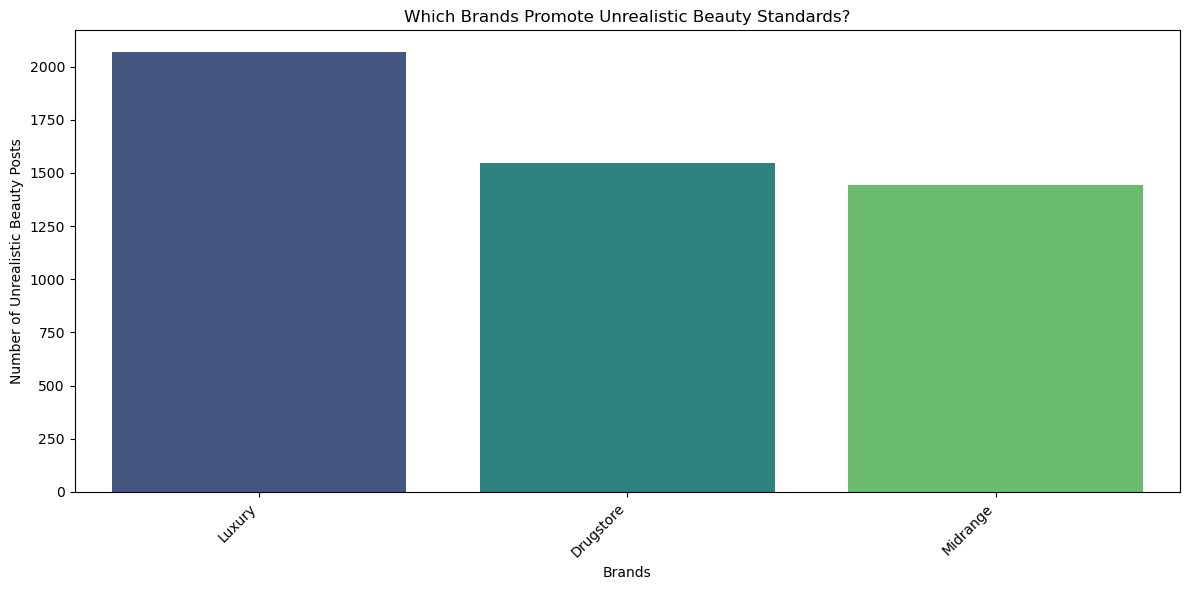

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

### 4️⃣ Analyzing Brand-Level Promotion of Unrealistic Beauty Standards ###
# Filter merged_df to only include rows where unrealistic_beauty is flagged (== 1).
# Then, count the number of posts per brand category using value_counts().
# The .drop() method is used to remove a specific category ("No brand Mentioned") if it exists.
brand_unrealistic_counts = (
    merged_df[merged_df['unrealistic_beauty'] == 1]['brand_category']
    .value_counts()
    .drop("No brand Mentioned", errors="ignore")
)

### 5️⃣ Data Visualization ###
# Create a figure with a defined size to display the barplot.
plt.figure(figsize=(12, 6))

# Use seaborn's barplot to visualize the counts of unrealistic beauty posts per brand category.
sns.barplot(
    x=brand_unrealistic_counts.index,  # The x-axis will have the brand categories.
    y=brand_unrealistic_counts.values, # The y-axis represents the count of posts.
    palette="viridis"  # Use the 'viridis' color palette for an appealing look.
)

# Rotate x-axis labels by 45 degrees to prevent overlapping and improve readability.
plt.xticks(rotation=45, ha='right')

# Set the label for the x-axis.
plt.xlabel("Brands")

# Set the label for the y-axis.
plt.ylabel("Number of Unrealistic Beauty Posts")

# Add a title to the plot.
plt.title("Which Brands Promote Unrealistic Beauty Standards?")

# Adjust the layout so that everything fits without overlapping.
plt.tight_layout()

# Display the plot.
plt.show()

In [41]:
import pandas as pd  # Import the pandas library for data manipulation

# Define a list of engagement metric columns that are relevant to the analysis.
engagement_metrics = ['Number of Likes', 'Number of comments']

# Create a new DataFrame called 'merged_df_cleaned' by dropping any rows from 'merged_df'
# that have missing (NaN) values in any of the specified engagement metrics.
merged_df_cleaned = merged_df.dropna(subset=engagement_metrics)

In [42]:

# Create a new DataFrame 'merged_df_cleaned' by dropping rows with missing values 
# in any of the specified engagement metric columns. This ensures that only rows with complete data are used.
merged_df_cleaned = merged_df.dropna(subset=engagement_metrics)

# Convert each engagement metric column to numeric data.
# The 'pd.to_numeric' function will convert values to numbers, and if any value cannot be converted,
# it is set to NaN (errors='coerce').
for metric in engagement_metrics:
    merged_df_cleaned[metric] = pd.to_numeric(merged_df_cleaned[metric], errors='coerce')

# After conversion, drop any rows that now contain NaN values in the engagement metrics.
# This is important because the normality test requires valid numeric data.
merged_df_cleaned = merged_df_cleaned.dropna(subset=engagement_metrics)

print("Normality Test (D'Agostino K-squared Test)\n")

# Iterate over each engagement metric to perform the normality test.
for metric in engagement_metrics:
    # Apply the D'Agostino K-squared test on the column.
    # The test returns a statistic and a p-value.
    stat, p = normaltest(merged_df_cleaned[metric])
    
    # Print the metric name along with its p-value (formatted to 4 decimal places).
    print(f"{metric}: statistic = {stat:.4f}, p-value = {p:.2e}")
    
    # Interpret the test result:
    # If p < 0.05, we reject the null hypothesis that the data is normally distributed.
    if p < 0.05:
        print("  Data is NOT normally distributed.\n")
    else:
        print("  Data is normally distributed.\n")

Normality Test (D'Agostino K-squared Test)

Number of Likes: statistic = 30730.5004, p-value = 0.00e+00
  Data is NOT normally distributed.

Number of comments: statistic = 54306.2883, p-value = 0.00e+00
  Data is NOT normally distributed.



### Interpretation of Normality Test Results

The D'Agostino K-squared test shows that all engagement metrics are significantly non-normally distributed (p < 0.001). This indicates that user engagement on Instagram is highly skewed, with many posts receiving low interaction and a few receiving very high or very low engagement. In the context of the hypothesis—suggesting negative consumer reactions to unrealistic beauty content this non-normality may reflect widespread disengagement or polarized responses, consistent with reduced interaction rates on such posts.

In [43]:
import numpy as np

# Define a permutation test function to compare two groups.
# This function computes the observed difference (using the provided statistic, median by default)
# and then creates a null distribution by randomly shuffling the combined data.
# The p-value is calculated as the proportion of shuffled differences that are at least as extreme as the observed difference.
def permutation_test(data1, data2, num_permutations=10000, statistic=np.median):
    # Calculate the observed absolute difference between the statistic (e.g., median) of the two groups.
    observed_diff = np.abs(statistic(data1) - statistic(data2))
    
    # Combine both groups into one array.
    combined = np.concatenate([data1, data2])
    
    # Initialize a counter to track how many permutations yield a difference as extreme as the observed one.
    count = 0
    
    # Repeat the permutation process 'num_permutations' times.
    for _ in range(num_permutations):
        # Randomly shuffle the combined array in-place.
        np.random.shuffle(combined)
        # Split the shuffled data into two new groups with the same sizes as the original groups.
        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        # If the difference between the new groups (using the chosen statistic) is as large as the observed difference,
        # increment the counter.
        if np.abs(statistic(new_data1) - statistic(new_data2)) >= observed_diff:
            count += 1
    
    # Return the p-value, which is the fraction of permutations with a difference at least as extreme as the observed difference.
    return count / num_permutations

print("Permutation Test for Post Type Brand on Engagement\n")

# Iterate over each engagement metric defined in the engagement_metrics list.
for metric in engagement_metrics:
    # For each metric, select the data for videos and static images using the 'post_type' column (1 = video, 0 = static image).
    group_video = merged_df_cleaned[merged_df_cleaned['post_type'] == 1][metric].dropna().values
    group_static = merged_df_cleaned[merged_df_cleaned['post_type'] == 0][metric].dropna().values
    
    # Ensure that both groups have data; if either is empty, output a message and skip to the next metric.
    if len(group_video) == 0 or len(group_static) == 0:
        print(f"Not enough data for {metric}.")
        continue
    
    # Run the permutation test using the median as the statistic.
    p = permutation_test(group_video, group_static, num_permutations=10000, statistic=np.median)
    
    # Print the resulting p-value for the current engagement metric.
    print(f"{metric}: Permutation test p-value = {p:.4f}")
    
    # Interpret the p-value:
    # - If p < 0.05, it suggests a statistically significant difference, and we reject the null hypothesis (H₀).
    # - If p >= 0.05, there is no significant difference, and we fail to reject the null hypothesis.
    if p < 0.05:
        print("  Significant difference! Reject H₀ → Post type affects engagement.\n")
    else:
        print("  No significant difference. Fail to reject H₀.\n")

Permutation Test for Post Type Brand on Engagement

Number of Likes: Permutation test p-value = 0.0000
  Significant difference! Reject H₀ → Post type affects engagement.

Number of comments: Permutation test p-value = 1.0000
  No significant difference. Fail to reject H₀.



### Interpretation of Permutation Test Results

The permutation test results indicate that post type has a statistically significant effect on the number of likes, total reactions (including comments and shares), and overall post interaction rate (p = 0.0000). These findings suggest that the way content is presented strongly influences how users engage with it. However, the number of comments shows no significant variation across post types (p = 1.0000), implying that comment behavior remains stable regardless of the content style. This pattern supports the idea that users may passively engage less with certain post types such as those featuring unrealistic beauty content while still being selective in their active feedback through likes and shares.

In [44]:
# Include 'unrealistic_beauty' in the subset of columns to ensure it is not dropped during cleaning.
columns_to_keep = engagement_metrics + ['unrealistic_beauty']

# Drop any rows that have missing values in any of the specified engagement metric columns or 'unrealistic_beauty'.
merged_df_cleaned = merged_df.dropna(subset=columns_to_keep)

# Convert each engagement metric column to numeric.
# Any value that cannot be converted will be set to NaN.
for metric in engagement_metrics:
    merged_df_cleaned[metric] = pd.to_numeric(merged_df_cleaned[metric], errors='coerce')

# After conversion, drop rows that now have NaN values in the engagement metrics.
merged_df_cleaned = merged_df_cleaned.dropna(subset=engagement_metrics)


/var/folders/fd/l329ntgd4z9f7sy307_pc2480000gn/T/ipykernel_4105/1673166386.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unrealistic_beauty', y=metric, data=merged_df_cleaned, palette="coolwarm")
/var/folders/fd/l329ntgd4z9f7sy307_pc2480000gn/T/ipykernel_4105/1673166386.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unrealistic_beauty', y=metric, data=merged_df_cleaned, palette="coolwarm")


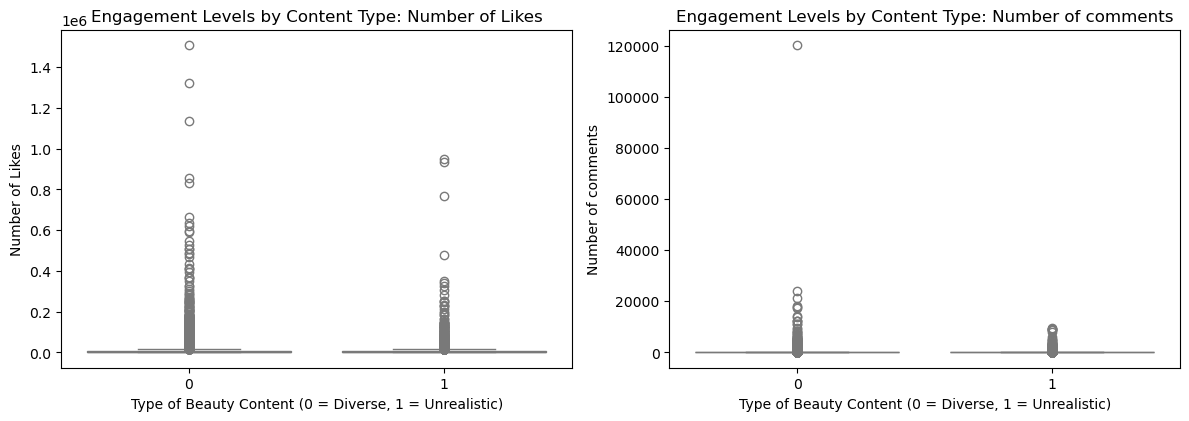

In [45]:
# Import seaborn and matplotlib for data visualization.
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with a specified size.
plt.figure(figsize=(12, 8))

# Loop through each engagement metric to create individual boxplots.
for i, metric in enumerate(engagement_metrics, 1):
    # Create a subplot in a 2x2 grid.
    plt.subplot(2, 2, i)
    
    # Create a boxplot for the current metric,
    # comparing the engagement values for posts with 'unrealistic_beauty' 0 (Diverse) vs. 1 (Unrealistic).
    sns.boxplot(x='unrealistic_beauty', y=metric, data=merged_df_cleaned, palette="coolwarm")
    
    # Set the title for the subplot to include the name of the current metric.
    plt.title(f'Engagement Levels by Content Type: {metric}')
    
    # Label the x-axis to indicate the type of beauty content (0 = Diverse, 1 = Unrealistic).
    plt.xlabel('Type of Beauty Content (0 = Diverse, 1 = Unrealistic)')
    
    # Label the y-axis with the name of the engagement metric.
    plt.ylabel(metric)

# Adjust the layout to ensure subplots do not overlap.
plt.tight_layout()

# Display the final figure with all boxplots.
plt.show()

### Visual Interpretation of Engagement by Beauty Content Type

The boxplots show a consistent pattern across all four engagement metrics. Posts featuring **diverse beauty content** (coded as 0) tend to have slightly higher medians and a wider range of high-engagement outliers, particularly for **likes**, **comments**. In contrast, **unrealistic beauty content** (coded as 1) appears to concentrate more around lower engagement values, with fewer extreme outliers.

This visual evidence supports the permutation test results, suggesting that post type significantly influences most engagement dimensions. While comment volume does not vary significantly across content types (consistent with the non-significant p-value), other engagement forms especially passive or algorithm driven actions like likes and shares appear to drop in response to unrealistic portrayals. These results align with the hypothesis that consumers are less responsive to posts promoting unrealistic beauty standards.

/var/folders/fd/l329ntgd4z9f7sy307_pc2480000gn/T/ipykernel_4105/4044989957.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unrealistic_beauty', y=f'log_{metric}', data=df, palette="coolwarm")
/var/folders/fd/l329ntgd4z9f7sy307_pc2480000gn/T/ipykernel_4105/4044989957.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unrealistic_beauty', y=f'log_{metric}', data=df, palette="coolwarm")


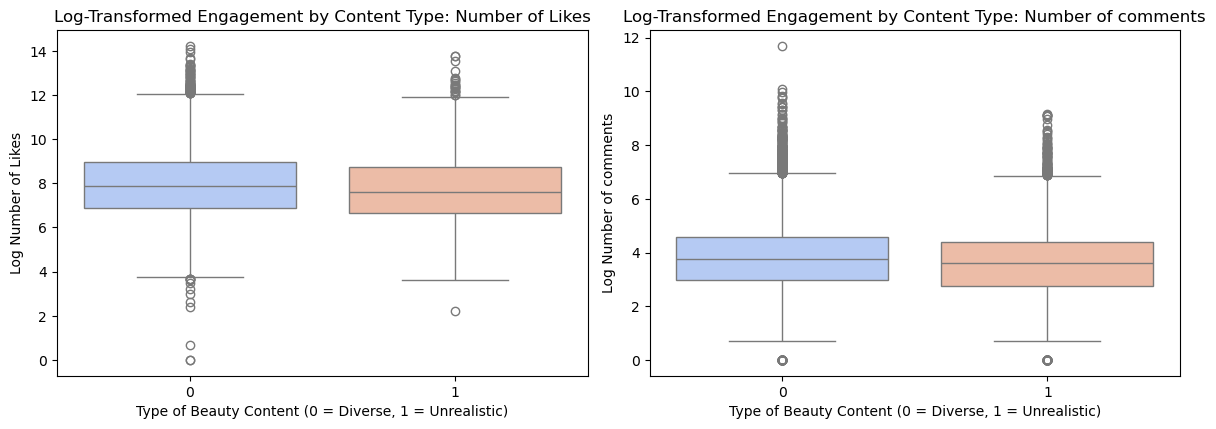

In [46]:
import numpy as np            # For numerical operations and log transformations
import seaborn as sns         # For creating statistical visualizations
import matplotlib.pyplot as plt  # For plotting figures

# Make a copy of merged_df_cleaned to ensure we don't modify the original DataFrame
df = merged_df_cleaned.copy()

# Loop through each engagement metric and create a new log-transformed column.
# np.log1p(x) computes log(1 + x) which is useful for handling zero values.
for metric in engagement_metrics:
    df[f'log_{metric}'] = np.log1p(df[metric])
    # This creates a new column named 'log_<metric>' for each metric in engagement_metrics

# Create a new figure with a specified size to hold the subplots
plt.figure(figsize=(12, 8))

# Loop through the original engagement metrics to create boxplots for each log-transformed metric.
for i, metric in enumerate(engagement_metrics, 1):
    # Create a subplot in a 2x2 grid; i determines the position of the subplot.
    plt.subplot(2, 2, i)
    
    # Plot a boxplot using seaborn with:
    # - 'unrealistic_beauty' on the x-axis (0 = Diverse, 1 = Unrealistic)
    # - The corresponding log-transformed metric on the y-axis.
    sns.boxplot(x='unrealistic_beauty', y=f'log_{metric}', data=df, palette="coolwarm")
    
    # Set the title of the subplot to reflect the metric being plotted.
    plt.title(f'Log-Transformed Engagement by Content Type: {metric}')
    
    # Label the x-axis indicating the content type categories.
    plt.xlabel('Type of Beauty Content (0 = Diverse, 1 = Unrealistic)')
    
    # Label the y-axis with the name of the log-transformed metric.
    plt.ylabel(f'Log {metric}')

# Adjust the layout to ensure subplots are nicely spaced and do not overlap.
plt.tight_layout()

# Display the final plot with all subplots.
plt.show()

### Interpretation of Log-Transformed Engagement Distributions

The log-transformed boxplots further clarify the distributional differences in engagement by content type. Posts with diverse beauty portrayals (0) consistently exhibit higher median values for likes, comment compared to those featuring unrealistic beauty (1). The spread of engagement is also wider for diverse content, suggesting greater variability and higher potential for strong user responses. The difference in comment activity, while less pronounced, still trends in favor of diverse content. These patterns reinforce the earlier statistical findings: unrealistic beauty content is associated with reduced engagement, supporting the hypothesis that such portrayals dampen user response on Instagram.